In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from matplotlib.mlab import griddata

In [2]:
import tensorflow as tf

In [3]:
import tensorflow.contrib.layers as layers
import tensorflow.contrib.distributions as ds

In [4]:
config = tf.ConfigProto(intra_op_parallelism_threads=8, inter_op_parallelism_threads=8, \
                        allow_soft_placement=True, device_count = {'CPU': 8})
sess = tf.InteractiveSession(config = config)

In [5]:
def prepare_data(n_samples):
    data = []
    labels = []
    nuisances = []
    
    for i in range(n_samples):
        sig_bkg = np.random.uniform(low = 0.0, high = 1.0, size = 1)
        if sig_bkg > 0.5:
            nuisance = np.random.uniform(low = 0.0, high = 2.0, size = 1)
            data.append(np.random.multivariate_normal(mean = [0.0, nuisance], cov = np.array([[1, -0.5], [-0.5, 1]]), size = 1).flatten())
            labels.append(1.0)
        else:
            nuisance = np.random.uniform(low = 0.0, high = 2.0, size = 1)
            data.append(np.random.multivariate_normal(mean = [1.0, nuisance], cov = np.eye(2), size = 1).flatten())
            labels.append(0.0)
            
        nuisances.append(nuisance)
    data = np.array(data)
    labels = np.array(labels)
    nuisances = np.array(nuisances)
    
    return data, labels, nuisances.flatten()

In [6]:
num_samples = 100000
data_train, labels_train, nuisances_train = prepare_data(num_samples)
nuisances_train = np.expand_dims(nuisances_train, axis = 1)

In [7]:
data_in = tf.placeholder(tf.float32, [None, 2], name = 'data_in')
nuisances_in = tf.placeholder(tf.float32, [None, 1], name = 'nuisances_in')
labels_in = tf.placeholder(tf.int32, [None, ], name = 'labels_in')
noise_in = tf.placeholder(tf.float32, [None, 2], name = 'noise_in')

In [8]:
def classifier(classifier_input, random_input):
    with tf.variable_scope("classifier"):
        #lay = tf.concat([classifier_input, random_input], axis = 1)
        lay = layers.relu(random_input, 50)
        lay = layers.relu(lay, 50)
        lay = layers.relu(lay, 20)
        lay = layers.relu(lay, 2)
        outputs = layers.softmax(lay)
        
    these_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope = "classifier")

    return outputs, these_vars

In [9]:
def EM_network(data, name, reuse = tf.AUTO_REUSE):
    with tf.variable_scope(name, reuse = reuse):       
        lay = layers.relu(data, 40)
        lay = layers.relu(lay, 40)
        lay = layers.relu(lay, 20)
        outputs = layers.linear(lay, 1)
        
    these_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope = name)
    
    return outputs, these_vars

In [10]:
def EM_loss(data_P, data_Q, name):
    local_EM_network_name = name + "_EM_net"
    
    T_P, EM_vars = EM_network(data_P, name = local_EM_network_name)
    T_Q, _ = EM_network(data_Q, name = local_EM_network_name)

    EM_loss = tf.reduce_mean(T_P, axis = 0) - tf.reduce_mean(T_Q, axis = 0)
    
    batch_size_dyn = tf.cast(tf.shape(T_P)[0], tf.int32)
    rand = tf.random.uniform(shape = (batch_size_dyn, 1), minval = 0.0, maxval = 1.0)
    
    # add gradient penalty
    x_grad = tf.math.add(tf.math.multiply(rand, data_P),
                         tf.math.multiply(tf.math.subtract(1.0, rand), data_Q))
    x_grad_EM, _ = EM_network(x_grad, name = local_EM_network_name)
    grad = tf.gradients(x_grad_EM, x_grad)[0]
    
    grad_pen = tf.reduce_mean(tf.square(tf.math.abs(grad) - 1.0), axis = 0)[0]

    EM_loss_grad_pen = EM_loss[0] + 10 * grad_pen

    return EM_loss_grad_pen, EM_vars, EM_loss

In [11]:
with tf.variable_scope('model_params'):
    low = tf.Variable(0.3, 'low')
    high = tf.Variable(0.03, 'high')

model_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope = 'model_params')

In [12]:
classifier_output, classifier_vars = classifier(data_in, noise_in)

In [13]:
classifier_output_expanded = tf.expand_dims(classifier_output[:,0], axis = 1)

In [14]:
bkg_indices = tf.where(tf.math.less(labels_in, 1))

In [15]:
classifier_bkg_input_samples = tf.gather_nd(data_in, bkg_indices)

In [16]:
classifier_bkg_samples = tf.gather_nd(classifier_output_expanded, bkg_indices)

In [17]:
model = ds.Normal(loc = low, scale = high)

In [18]:
#batch_size_dyn = tf.cast(tf.shape(classifier_bkg_samples)[0], tf.int32)
samples_model = model.sample((5000, 1))

In [19]:
EM_lossval, EM_vars, critic = EM_loss(samples_model, classifier_output_expanded, 'EM_loss')

In [20]:
labels_one_hot = tf.one_hot(labels_in, depth = 2)

In [21]:
classification_loss = tf.losses.softmax_cross_entropy(onehot_labels = labels_one_hot, logits = classifier_output)

In [22]:
EM_regularized_loss = 10 * tf.math.square(critic) #classification_loss

In [23]:
train_regularized_classifier = tf.train.AdamOptimizer(learning_rate = 0.005, beta1 = 0.0, beta2 = 0.9).minimize(EM_regularized_loss, var_list = classifier_vars)

In [1]:
train_EM = tf.train.AdamOptimizer(learning_rate = 0.005, beta1 = 0.9, beta2 = 0.999).minimize(EM_lossval, var_list = EM_vars)

NameError: name 'tf' is not defined

In [25]:
# combined training
classification_loss_evolution = []
MI_evolution = []
number_batches = 200
MINE_batches = 300

In [26]:
number_epochs = 10

In [27]:
sess.run(tf.global_variables_initializer())

In [28]:
train_bkg = labels_train == 0
bkg_data_train = data_train[train_bkg]
bkg_labels_train = labels_train[train_bkg]

In [29]:
train_sig = labels_train == 1
sig_data_train = data_train[train_sig]
sig_labels_train = labels_train[train_sig]

In [88]:
init_EM = tf.variables_initializer(var_list = EM_vars)

In [115]:
sess.run(init_EM)

In [116]:
# pre-train EM
for batch in range(2000):
    inds = np.random.choice(len(bkg_data_train), 5000)
    bkg_batch_data = bkg_data_train[inds]
    bkg_batch_labels = bkg_labels_train[inds]
    noise_batch = np.random.uniform(low = 0.0, high = 1.0, size = (5000, 2))
    
    #a_cur, b_cur = sess.run([classifier_bkg_samples, samples_model], feed_dict = {data_in: bkg_batch_data, labels_in: bkg_batch_labels})
    #a.append(a_cur)
    #b.append(b_cur)
    
    sess.run([train_EM], feed_dict = {data_in: bkg_batch_data, labels_in: bkg_batch_labels, noise_in: noise_batch})
    
    if not batch % 200:
        cur_EM = sess.run(critic, feed_dict = {data_in: bkg_batch_data, labels_in: bkg_batch_labels, noise_in: noise_batch})
        print("EM = {}".format(cur_EM))

EM = [0.01991475]
EM = [0.02873889]
EM = [0.02897778]
EM = [0.02995726]
EM = [0.03145203]
EM = [0.02846572]
EM = [0.02944851]
EM = [0.02947399]
EM = [0.02930182]
EM = [0.02982208]


In [31]:
cur_EM = sess.run(critic, feed_dict = {data_in: bkg_batch_data, labels_in: bkg_batch_labels, noise_in: noise_batch})
print("critic after pre-training = {}".format(cur_EM))

critic after pre-training = [-0.20149115]


In [125]:
for epoch in range(1):
    print("epoch {}".format(epoch))
    
    for batch in range(1):
        
        # update EM
        for i in range(2000):
            inds = np.random.choice(len(bkg_data_train), 5000)
            bkg_batch_data = bkg_data_train[inds]
            bkg_batch_labels = bkg_labels_train[inds]
            noise_batch = np.random.uniform(low = 0.0, high = 1.0, size = (5000, 2))
    
            sess.run([train_EM], feed_dict = {data_in: bkg_batch_data, labels_in: bkg_batch_labels, noise_in: noise_batch})      
    
        # train regularized classifier on sig + bkg
        inds_bkg = np.random.choice(len(bkg_data_train), 5000)
        bkg_batch_data = bkg_data_train[inds_bkg]
        bkg_batch_labels = bkg_labels_train[inds_bkg]
        noise_batch = np.random.uniform(low = 0.0, high = 1.0, size = (5000, 2))

        #inds_sig = np.random.choice(len(sig_data_train), 5000)
        #sig_batch_data = sig_data_train[inds_sig]
        #sig_batch_labels = sig_labels_train[inds_sig]

        #data_batch = np.concatenate([sig_batch_data, bkg_batch_data])
        #labels_batch = np.concatenate([sig_batch_labels, bkg_batch_labels])
        
        data_batch = bkg_batch_data
        labels_batch = bkg_batch_labels
        
        #critic_val = sess.run(critic, feed_dict = {data_in: data_batch, labels_in: labels_batch})
        #print("critic before training classifier = {}".format(critic_val))
        
        sess.run(train_regularized_classifier, feed_dict = {data_in: data_batch, labels_in: labels_batch, noise_in: noise_batch})
                
        if not batch % 1:
            critic_val = sess.run(critic, feed_dict = {data_in: data_batch, labels_in: labels_batch, noise_in: noise_batch})
            class_loss = sess.run(classification_loss, feed_dict = {data_in: data_batch, labels_in: labels_batch, noise_in: noise_batch})
            tot_loss = sess.run(EM_regularized_loss, feed_dict = {data_in: data_batch, labels_in: labels_batch, noise_in: noise_batch})
            print("class_loss = {}, critic = {}, tot = {}".format(class_loss, critic_val, tot_loss))

epoch 0
class_loss = 0.9265249967575073, critic = [-0.01098806], tot = [0.00088103]


In [31]:
data_test = np.loadtxt("data_test.txt")
nuisances_test = np.loadtxt("nuisances_test.txt")
labels_test = np.loadtxt("labels_test.txt")

In [107]:
sig = data_test[labels_test == 1]
bkg = data_test[labels_test == 0]
noise_sig = np.random.uniform(low = 0.0, high = 1.0, size = sig.shape)
noise_bkg = np.random.uniform(low = 0.0, high = 1.0, size = bkg.shape)

In [126]:
pred_sig = sess.run(classifier_output, feed_dict = {data_in: sig, noise_in: noise_sig})
pred_bkg = sess.run(classifier_output, feed_dict = {data_in: bkg, noise_in: noise_bkg})

In [127]:
target = [sess.run(samples_model) for i in range(10)]

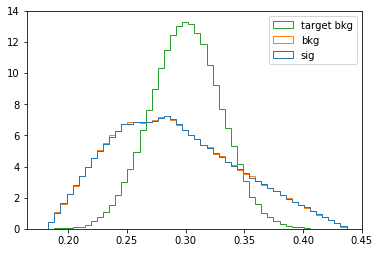

In [128]:
plt.hist([pred_sig[:,0], pred_bkg[:,0], target], label = ['sig', 'bkg', 'target bkg'], histtype = 'step', density = True, stacked = False, fill = False, bins = 50)
plt.legend()
plt.show()